# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import random

from PIL import Image

import cv2

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.backend import epsilon

import warnings
warnings.filterwarnings('ignore')

### Change directory

In [2]:
from google.colab import drive
drive.mount('/content/Anton', force_remount=True)

import os

project_path = "/content/Anton/My Drive/Colab Notebooks/Adv Computer Vision/"
os.chdir(project_path)
print(os.getcwd())

Mounted at /content/Anton
/content/Anton/My Drive/Colab Notebooks/Adv Computer Vision


### Load the training data from train.csv file

In [3]:
Y = pd.read_csv("./train_labels.csv")
Y.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [4]:
Y.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [5]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [6]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    csv_reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(csv_reader, None)
    for i,row in enumerate(csv_reader):
 
        for j, r in enumerate(row):

            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
    
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)

        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width 
        coords[i,3] = ymax * IMAGE_SIZE / height 

In [7]:
coords

array([[4.69498069e+01, 3.95876289e+01, 8.25328185e+01, 7.78556701e+01],
       [5.81818182e-01, 2.96296296e-01, 8.94060606e+01, 1.27703704e+02],
       [1.57866667e+01, 3.42400000e+01, 5.97333333e+01, 9.28000000e+01],
       [4.84266667e+01, 2.97600000e+01, 8.59733333e+01, 9.53600000e+01],
       [2.71941392e+01, 2.28324324e+01, 9.23663004e+01, 8.78702703e+01],
       [7.49268293e+00, 5.72357724e+00, 1.17385366e+02, 1.24878049e+02],
       [2.53866667e+01, 6.72000000e+00, 7.85066667e+01, 1.27680000e+02],
       [5.24750958e+01, 6.63212435e+00, 1.22114943e+02, 1.10093264e+02],
       [5.14056225e-01, 6.33663366e-01, 7.91646586e+01, 1.11524752e+02],
       [4.29961390e+01, 5.27835052e+00, 8.99459459e+01, 5.87216495e+01],
       [1.30957096e+01, 4.62650602e+00, 8.32211221e+01, 1.25686747e+02],
       [8.40154440e+00, 2.57319588e+01, 1.18115830e+02, 9.69896907e+01],
       [4.35200000e+00, 3.12320000e+01, 7.14240000e+01, 1.27744000e+02],
       [6.83333333e+00, 6.66666667e-01, 1.13833333e

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [10]:
images = "./images/images/"

batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
  img = Image.open(images+f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [11]:
len(batch_images)

173

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [12]:
ALPHA = 1.0

model = MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top= False, alpha=ALPHA)

for layer in model.layers:
  layer.trainable = False

x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x)

model = Model(inputs=model.input, outputs=x)

17227776/17225924 [==============================] - 0s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [13]:
import tensorflow as tf

def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [14]:
tf.keras.backend.clear_session()

In [15]:
model.compile(optimizer = "Adam", loss = "mse", metrics = [IoU])

In [16]:
model.fit(batch_images, coords, batch_size=32, verbose=1, epochs=30)

Epoch 1/30
6/6 [==============================] - 2s 318ms/step - loss: 3987.1272 - IoU: 0.0756
Epoch 2/30
6/6 [==============================] - 2s 317ms/step - loss: 743.5263 - IoU: 0.4263
Epoch 3/30
6/6 [==============================] - 2s 314ms/step - loss: 472.5928 - IoU: 0.5683
Epoch 4/30
6/6 [==============================] - 2s 313ms/step - loss: 618.3086 - IoU: 0.5392
Epoch 5/30
6/6 [==============================] - 2s 314ms/step - loss: 346.6240 - IoU: 0.6207
Epoch 6/30
6/6 [==============================] - 2s 310ms/step - loss: 194.7363 - IoU: 0.6638
Epoch 7/30
6/6 [==============================] - 2s 314ms/step - loss: 199.6406 - IoU: 0.6579
Epoch 8/30
6/6 [==============================] - 2s 312ms/step - loss: 163.4192 - IoU: 0.7011
Epoch 9/30
6/6 [==============================] - 2s 314ms/step - loss: 124.8034 - IoU: 0.7432
Epoch 10/30
6/6 [==============================] - 2s 313ms/step - loss: 111.9078 - IoU: 0.7655
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

In [17]:
test_img = random.choice(paths)
filename = images + test_img
unscaled = cv2.imread(filename)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [18]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [19]:
region = model.predict(x = np.array([feat_scaled]))[0]
region

array([ 30.048233,   9.031185,  97.05393 , 111.4232  ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

Rectangle(xy=(112, 25), width=251, height=288, angle=0)


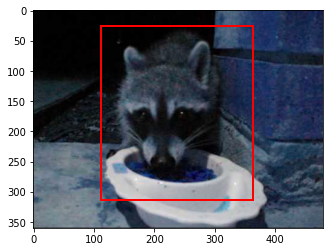

In [20]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')
print(rect)

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()